We solve the steady advection-diffusion equation $$-\kappa \Delta u + \mathbf{a}\cdot \nabla u = 0, \quad\text{where }\kappa =10^{-7} \text{ and } \mathbf{a} = \left(-y + 0.5\,,\,\, x - 0.5\right)^T $$

The domain is $0\le x, y\le 1$ and our solution satisfies the dirichlet boundary conditions indicated below. Especially important (in terms of stability) is the sine wave that extends from the center of the square to an edge.
<img src="files/ProblemSetup.png">
(pictures taken from this [paper](https://link.springer.com/content/pdf/10.1007/s11831-010-9042-5.pdf))

The exact solution (in the hyperbolic limit) is a solid of revolution of the sine wave about the z-axis through the center of the square.






In [1]:
import nutils as ntl
import numpy as np
import matplotlib.pyplot as plt
import inspect
from matplotlib import collections
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

## Galerkin

**Weak Form**: $$0 = \int_\Omega \kappa \, N_{A, j}\, u_{, j} \,-\, u\, N_{A, k} \,a_k \, dx$$
where $N_i$ is a basis function.

<class 'nutils.topology.Topology'> <class 'nutils.topology.SubsetTopology'> <class 'nutils.topology.SubsetTopology'>
optimize > solve > solving 90 dof system to machine precision using direct solver
optimize > solve > solver returned with residual 1e-18
optimize > constrained 90/441 dofs
optimize > optimum value 5.75e-08
solve > solving 351 dof system to machine precision using direct solver
solve > solver returned with residual 9e-18


<IPython.core.display.Javascript object>


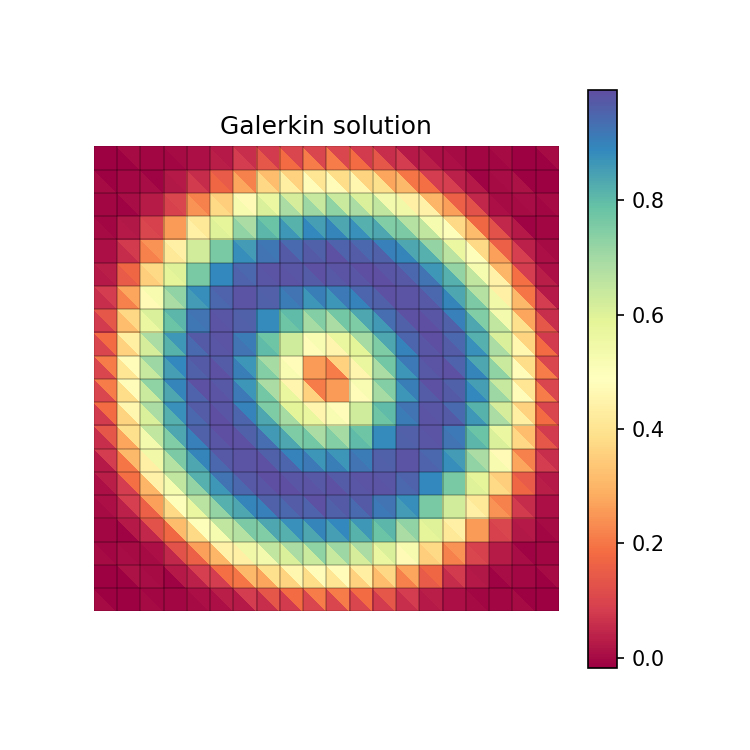

<IPython.core.display.Javascript object>


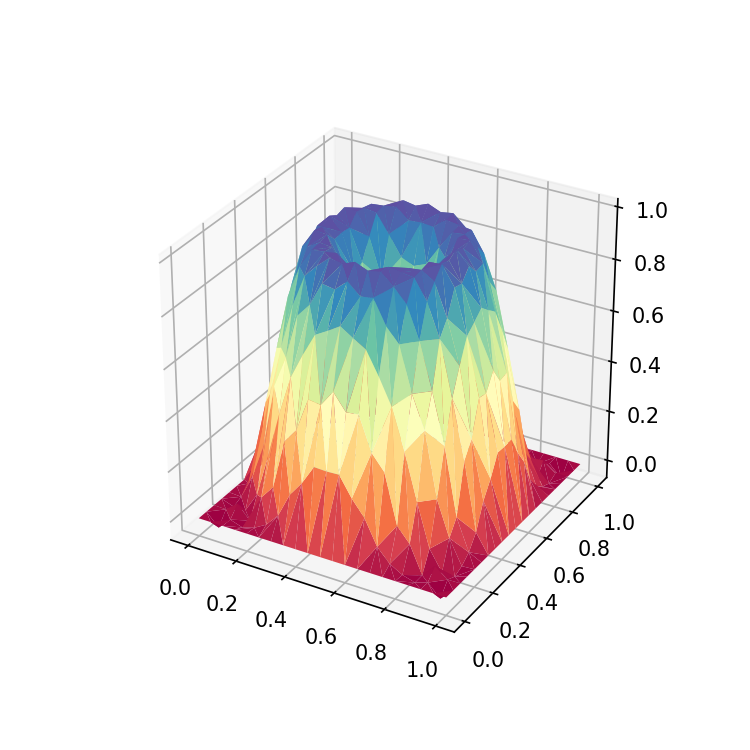

In [34]:
import nutils as ntl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

degree = 1 #degree of basis functions
nelems = 20 #number of elements along edge of unit square
etype = 'square' #square meshes

topo, geom =ntl.mesh.unitsquare(nelems, etype) #ntl.mesh.gmsh('domain.msh') #
ns = ntl.function.Namespace()
ns.x = geom
ns.a = [- geom[1] + 0.5, geom[0] - 0.5]  
ns.kappa = 1e-7
ns.pi = np.pi
ns.basis = topo.basis('lagrange', degree = degree)
ns.u = 'basis_i ?dofs_i'
 
#print(type(topo.boundary)) 

#Dirichlet boundary condition
#tophalf of domain is defined via y - 0.5 > 0. Midline is one of the boundaries of this new domain 
halftopo = topo.trim(geom[1] - 0.50, maxrefine = 0, name= 'halfbnd') 
halfbnd = halftopo.boundary['halfbnd']
midline = halfbnd.trim(geom[0] - 0.5, maxrefine = 0) #Pick variable names better than me 
madline = midline.trim(0.75 - geom[1], maxrefine = 0) # this is the boundary we want

print(type(halfbnd), type(midline), type(madline))

sqr = madline.integral('( u - sin(2 pi (x_0 - 0.5))  )^2 d:x' @ ns, degree = degree * 2)#

sqr += topo.boundary['left'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['bottom'].integral('(u - 0)^2 d:x' @ ns, degree = degree*2)
sqr += topo.boundary['right'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['top'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
cons = ntl.solver.optimize('dofs', sqr, droptol=1e-15) #this applies the boundary condition to u

#residual
res = topo.integral( '(kappa basis_i,j u_,j  - u basis_i,n a_n) d:x' @ ns, degree = degree * 2) 
lhs = ntl.solver.solve_linear('dofs', res, constrain= cons)

#this converts our solution into arrays
bezier = topo.sample('bezier', 2)
x = bezier.eval('x_i' @ ns)
u = bezier.eval('u' @ ns, dofs = lhs)

#ntl.export.triplot('RF_Gal.png', x, u, tri=bezier.tri, hull=bezier.hull)
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111, aspect= 'equal')
im = ax.tripcolor(x[:,0], x[:, 1], bezier.tri, u, cmap = plt.cm.Spectral)
fig.colorbar(im)
ax.autoscale(enable= True, axis = 'both', tight = 'True')
ax.set_title('Galerkin solution')
ax.add_collection(collections.LineCollection(x[bezier.hull], colors='k', linewidths= .1))
plt.axis('off')

fig2 = plt.figure(figsize= (5,5))
ax2 = fig2.add_subplot(111, projection ='3d')
ax2.plot_trisurf( x[:, 0], x[:,1], u, cmap=plt.cm.Spectral)

## SUPG

**Weak Form**:
$$0 = \int_\Omega \kappa \, N_{A, j}\, u_{, j} \,-\, u\, N_{A, k}\,a_k \, dx + \int_\Omega \tau\, a_n N_{A, n} 
( - \kappa\, u_{, mm} + a_k\, u_{,k}) \, dx$$

We use $\tau = \frac{h}{2|a|}$ in the code below

optimize > solve > solving 90 dof system to machine precision using direct solver
optimize > solve > solver returned with residual 1e-18
optimize > constrained 90/441 dofs
optimize > optimum value 5.75e-08
solve > solving 351 dof system to machine precision using direct solver
solve > solver returned with residual 2e-17


<IPython.core.display.Javascript object>


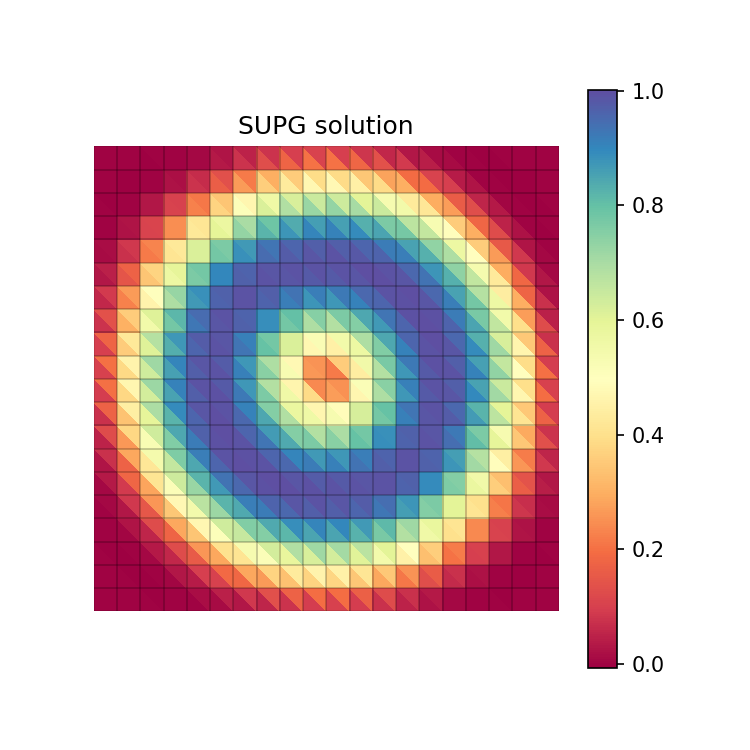

<IPython.core.display.Javascript object>


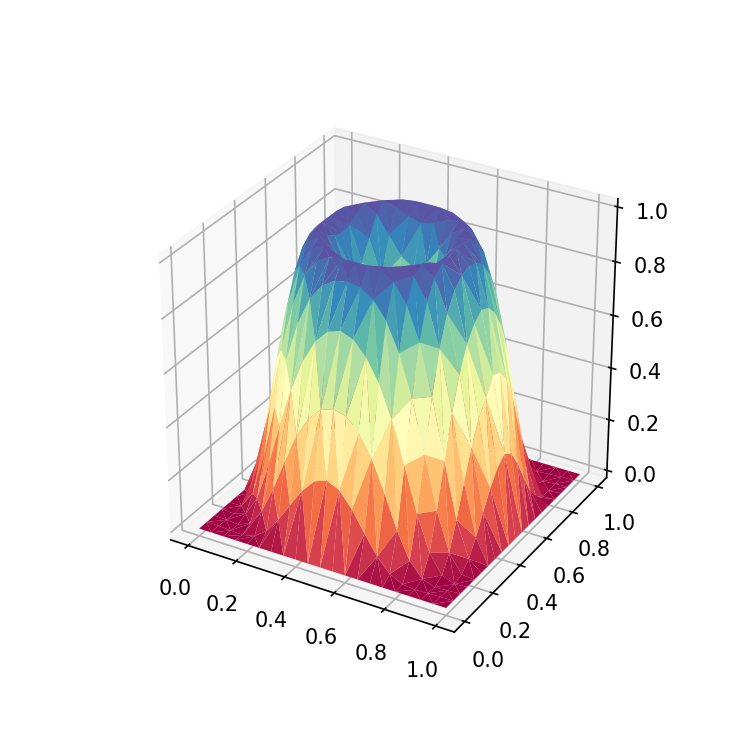

In [43]:
import nutils as ntl
import numpy as np
import matplotlib.pyplot as plt
import inspect
from matplotlib import collections
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

degree = 1 #degree of basis functions
nelems = 20 #number of elements along edge of unit square
etype = 'square' #square meshes


topo, geom =  ntl.mesh.unitsquare(nelems, etype) 
ns = ntl.function.Namespace()
ns.x = geom
ns.a = [- geom[1] + 0.5, geom[0] - 0.5]  
ns.kappa = 1e-7
ns.pi = np.pi
ns.basis = topo.basis('lagrange', degree = degree)
ns.u = 'basis_i ?dofs_i'

#element intrinsic time scale
ns.h = np.sqrt(2/nelems**2) #mesh size parameter
ns.anorm = '(a_i a_i)^.5'
ns.tau = 'h / (2 anorm)'

#dirichlet boundary conditions

halftopo = topo.trim(geom[1] - 0.5, maxrefine = 5, name= 'halfbnd') #this creates a topology for top half of square domain

halfbnd = halftopo.boundary['halfbnd'] #the midline is one of the boundaries of the top
#print(halfbnd.ndims, type(halfbnd))
midline = halfbnd.trim(geom[0] - 0.5, maxrefine = 0)# 
madline = midline.trim(0.75 - geom[1], maxrefine = 0)

sqr = madline.integral('( u - abs(sin(2 pi (x_0 - 0.5))) )^2 d:x' @ ns, degree = degree * 2)
sqr += topo.boundary['top'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['bottom'].integral('(u - 0)^2 d:x' @ ns, degree = degree*2)
sqr += topo.boundary['left'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['right'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )

cons = ntl.solver.optimize('dofs', sqr, droptol=1e-15) #this applies the boundary condition to u

#residual
res = topo.integral( '(kappa basis_i,j u_,j  - u basis_i,n a_n) d:x' @ ns, degree = degree * 2) 
res += topo.integral( 'tau a_k basis_i,k (-kappa u_,jj + a_n u_,n)  d:x' @ ns, degree = degree * 2) 

lhs = ntl.solver.solve_linear('dofs', res, constrain= cons)

bezier = topo.sample('bezier', 2)
x = bezier.eval('x_i' @ ns)
u = bezier.eval('u' @ ns, dofs = lhs)

#ntl.export.triplot('RF_SUPG.png', x, u, tri=bezier.tri, hull=bezier.hull)
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111, aspect= 'equal')
im = ax.tripcolor(x[:,0], x[:, 1], bezier.tri, u, cmap= plt.cm.Spectral)
fig.colorbar(im)
ax.autoscale(enable= True, axis = 'both', tight = 'True')
ax.set_title('SUPG solution')
ax.add_collection(collections.LineCollection(x[bezier.hull], colors='k', linewidths= .1))
plt.axis('off')

fig2 = plt.figure(figsize= (5,5))
ax2 = fig2.add_subplot(111, projection ='3d')
ax2.plot_trisurf( x[:, 0], x[:,1], u, cmap=plt.cm.Spectral)


## Galerkin/Least Squares

**Weak Form**:
$$0 = \int_\Omega \kappa \, N_{A, j}\, u_{, j} \,-\, u\, N_{A, k}\,a_k \, dx + \int_\Omega \tau\, (-\kappa\,N_{A, rr}\,+\, a_n N_{A, n}) 
( - \kappa\, u_{, mm} + a_k\, u_{,k}) \, dx$$

We use $\tau = \frac{h}{2|a|}$ in the code below. (In the code below I use quadratic basis elements. Otherwise the method reduces to SUPG)

optimize > solve > solving 180 dof system to machine precision using direct solver
optimize > solve > solver returned with residual 1e-17
optimize > constrained 180/1681 dofs
optimize > optimum value 4.36e-09
solve > solving 1501 dof system to machine precision using direct solver
solve > solver returned with residual 9e-17


<IPython.core.display.Javascript object>


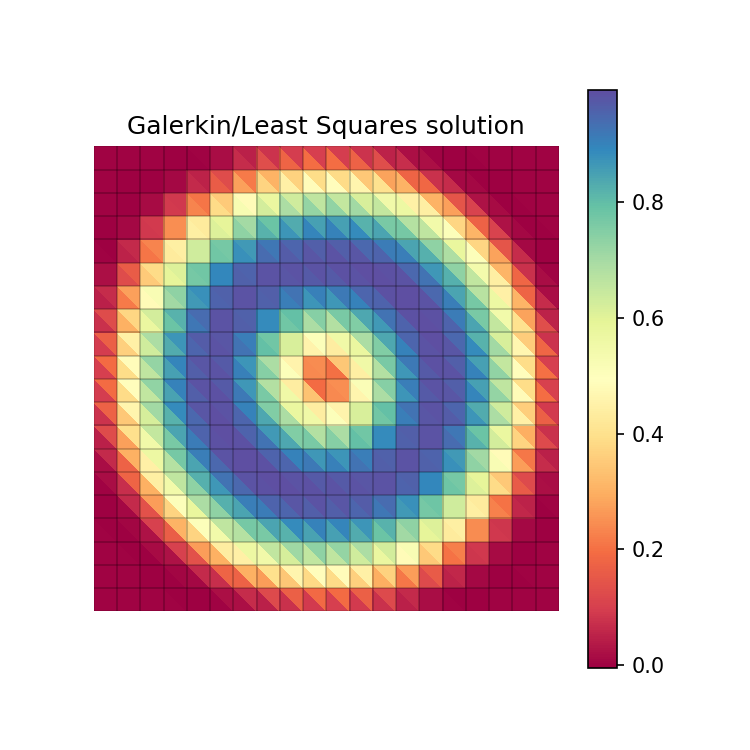

<IPython.core.display.Javascript object>


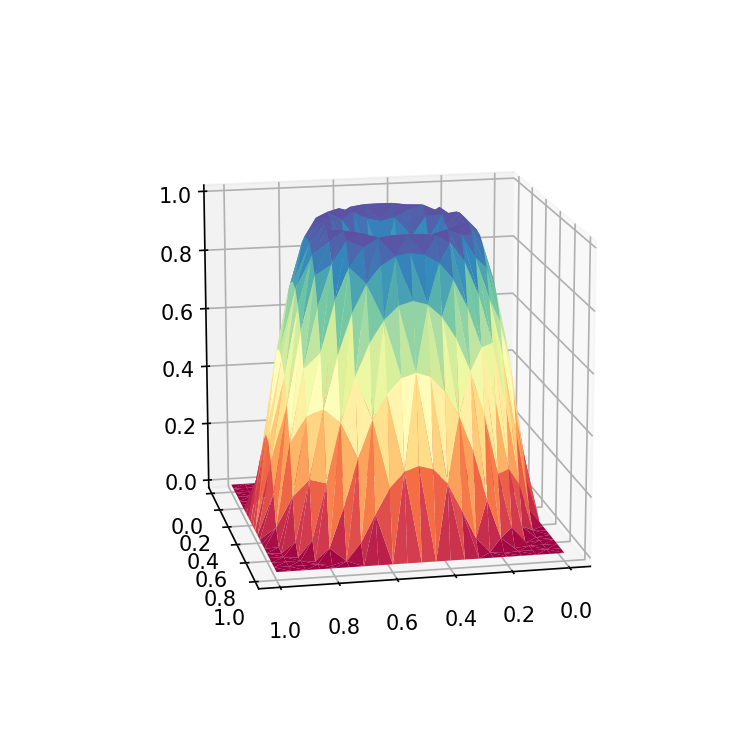

In [45]:
import nutils as ntl
import numpy as np
import matplotlib.pyplot as plt
import inspect
from matplotlib import collections
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

degree = 2 #degree of basis functions
nelems = 20 #number of elements along edge of unit square
etype = 'square' #square meshes


topo, geom =  ntl.mesh.unitsquare(nelems, etype) 
ns = ntl.function.Namespace()
ns.x = geom
ns.a = [- geom[1] + 0.5, geom[0] - 0.5]  
ns.kappa = 1e-7
ns.pi = np.pi
ns.basis = topo.basis('lagrange', degree = degree)
ns.u = 'basis_i ?dofs_i'

#element intrinsic time scale
ns.h = np.sqrt(2/nelems**2) #mesh size parameter
ns.anorm = '(a_i a_i)^.5'
ns.tau = 'h / (2 anorm)'

#dirichlet boundary conditions

halftopo = topo.trim(geom[1] - 0.5, maxrefine = 5, name= 'halfbnd') #this creates a topology for top half of square domain

halfbnd = halftopo.boundary['halfbnd'] #the midline is one of the boundaries of the top
#print(halfbnd.ndims, type(halfbnd))
midline = halfbnd.trim(geom[0] - 0.5, maxrefine = 0)# 
madline = midline.trim(0.75 - geom[1], maxrefine = 0)

sqr = topo.boundary['top'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['bottom'].integral('(u - 0)^2 d:x' @ ns, degree = degree*2)
sqr += topo.boundary['left'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['right'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
sqr += madline.integral('( u - abs(sin(2 pi (x_0 - 0.5))) )^2 d:x' @ ns, degree = degree * 2)

cons = ntl.solver.optimize('dofs', sqr, droptol=1e-15) #this applies the boundary condition to u

#residual
res = topo.integral( '(kappa basis_i,j u_,j  - u basis_i,n a_n) d:x' @ ns, degree = degree * 2) 
res += topo.integral('tau (-kappa basis_i,mm + a_k basis_i,k) (-kappa u_,jj + a_n u_,n)  d:x' @ ns,
                     degree= degree * 2) 
lhs = ntl.solver.solve_linear('dofs', res, constrain= cons)

bezier = topo.sample('bezier', 2)
x = bezier.eval('x_i' @ ns)
u = bezier.eval('u' @ ns, dofs = lhs)

#ntl.export.triplot('ADSM_GLS.png', x, u, tri=bezier.tri, hull=bezier.hull)
fig = plt.figure(figsize= (5,5))
ax = fig.add_subplot(111, aspect= 'equal')
im = ax.tripcolor(x[:,0], x[:, 1], bezier.tri, u, cmap= plt.cm.Spectral)
fig.colorbar(im)
ax.autoscale(enable= True, axis = 'both', tight = 'True')
ax.set_title('Galerkin/Least Squares solution')
ax.add_collection(collections.LineCollection(x[bezier.hull], colors='k', linewidths= .1))
plt.axis('off')

fig2 = plt.figure(figsize= (5,5))
ax2 = fig2.add_subplot(111, projection ='3d')
ax2.plot_trisurf( x[:, 0], x[:,1], u, cmap=plt.cm.Spectral)

## Potential practice problem

- The donut problem is usually defined on a square centred at the origin but the default unit square in Nutils is centred at $(\frac{1}{2}, \frac{1}{2})$. The advection term used in this notebook is a translation of the advection term you would usually see in a paper to Nutil's default unit square. For practice, you could try coding up the problem the standard way i.e. on a square centred at the origin. 

In [ ]:
help(halftopo.references)